# Update (version 18)
This version has a massive speedup, from 138s per epoch to 42s per epoch, with large steps_per_executin and BS 128.  
You can get another speedup of ~25% (from 42s to 32s) with a global mixed precision policy of bfloat16 (thank you, Jayoo Hwang, for this pointer!) at the cost of 0.001 accuracy. I prefer the accuracy, but if the 10s speedup is important to you, you can get it with the following:  

policyConfig = 'mixed_bfloat16'  
policy = tf.keras.mixed_precision.Policy(policyConfig)  
tf.keras.mixed_precision.set_global_policy(policy)  

And a minor alteration of the positional encoding layer to make it compatible.  
You can get another minor speedup with BS 256 (38s, 27s with bfloat16 global mixed precision policy). Since it is so tiny, BS 128 is probably the ideal one. If you have exciting findings regarding speed optimization, particularly if you can achieve another massive speedup or train with mixed precision without sacrificing accuracy, please share it in the comments for the common good of all of us low-budget folks without a private 4090...  
p.s. I always thought that TPU already makes matrix multiplications in bfloat16, so I don't understand why setting bfloat16 mixed precision policy gives another boost. If anyone here knows the answer, please enlighten me.  
p.p.s. Since I now have a massive speedup, I increased the epochs from 200 to 400 because why not. I don't know if that will improve accuracy; we will find out together. So, for anyone interested in the previous results, this notebook can achieve approximately 0.1300-0.1303 validation score with 200 epochs.

12-layers small (192 dim) transformer structure, same as [this notebook](https://www.kaggle.com/code/iafoss/rna-starter-0-186-lb)  .        
AdamW optimizer.  
Batch size ~64~ 128.  
~200~ 400 epochs.  
[Inference notebook](https://www.kaggle.com/code/shlomoron/srrf-transformer-tpu-inference)

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import math
import pandas as pd
import gc
import os

2023-11-02 12:43:39.308168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 12:43:39.308208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 12:43:39.308233: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 12:43:39.315990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# TPU boilerplate code

In [2]:
# Configure Strategy. Assume TPU...if not set default for GPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except:
    strategy = tf.distribute.get_strategy()

# Configs

In [3]:
DEBUG = False

PAD_x = 0.0
PAD_y = np.nan
X_max_len = 206
batch_size = 128
val_batch_size = 5512


if DEBUG:
    batch_size = 2
    val_batch_size = 2

num_vocab = 5
hidden_dim = 192

# Data API pipeline
This section applies filtering, preprocessing, shuffling, paddings, and batchings. I already transformed all the data to TFRecords; you can find the TFRecords dataset [here](https://www.kaggle.com/datasets/shlomoron/srrf-tfrecords-ds). I shuffled the samples before creating the TFRecords.

In [4]:
tffiles_path = '/home/kineticengines/app/datasets/as_tfrecords/tfds'
tffiles = [f'{tffiles_path}/{x}.tfrecord' for x in range(164)]

## Decoding TFRecords

In [5]:
def decode_tfrec(record_bytes):
    schema = {}
    schema["id"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["seq"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["dataset_name_2A3"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["dataset_name_DMS"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["reads_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reads_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["signal_to_noise_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["signal_to_noise_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["SN_filter_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["SN_filter_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    features = tf.io.parse_single_example(record_bytes, schema)

    sample_id = tf.sparse.to_dense(features["id"])
    seq = tf.sparse.to_dense(features["seq"])
    dataset_name_2A3 = tf.sparse.to_dense(features["dataset_name_2A3"])
    dataset_name_DMS = tf.sparse.to_dense(features["dataset_name_DMS"])
    reads_2A3 = tf.sparse.to_dense(features["reads_2A3"])
    reads_DMS = tf.sparse.to_dense(features["reads_DMS"])
    signal_to_noise_2A3 = tf.sparse.to_dense(features["signal_to_noise_2A3"])
    signal_to_noise_DMS = tf.sparse.to_dense(features["signal_to_noise_DMS"])
    SN_filter_2A3 = tf.sparse.to_dense(features["SN_filter_2A3"])
    SN_filter_DMS = tf.sparse.to_dense(features["SN_filter_DMS"])
    reactivity_2A3 = tf.sparse.to_dense(features["reactivity_2A3"])
    reactivity_DMS = tf.sparse.to_dense(features["reactivity_DMS"])
    reactivity_error_2A3 = tf.sparse.to_dense(features["reactivity_error_2A3"])
    reactivity_error_DMS = tf.sparse.to_dense(features["reactivity_error_DMS"])

    out = {}
    out['seq']  = seq
    out['SN_filter_2A3']  = SN_filter_2A3
    out['SN_filter_DMS']  = SN_filter_DMS
    out['reads_2A3']  = reads_2A3
    out['reads_DMS']  = reads_DMS
    out['signal_to_noise_2A3']  = signal_to_noise_2A3
    out['signal_to_noise_DMS']  = signal_to_noise_DMS
    out['reactivity_2A3']  = reactivity_2A3
    out['reactivity_DMS']  = reactivity_DMS
    return out

## Filtering

In [6]:
def f1(): return True
def f2(): return False

def filter_function_1(x):
    SN_filter_2A3 = x['SN_filter_2A3']
    SN_filter_DMS = x['SN_filter_DMS']
    return tf.cond((SN_filter_2A3 == 1) and (SN_filter_DMS == 1) , true_fn=f1, false_fn=f2)

def filter_function_2(x):
    reads_2A3 = x['reads_2A3']
    reads_DMS = x['reads_DMS']
    signal_to_noise_2A3 = x['signal_to_noise_2A3']
    signal_to_noise_DMS = x['signal_to_noise_DMS']
    cond = (reads_2A3>100 and signal_to_noise_2A3>0.75) or (reads_DMS>100 and signal_to_noise_DMS>0.75)
    return tf.cond(cond, true_fn=f1, false_fn=f2)

## Preprocessing

In [7]:
def nan_below_filter(x):
    reads_2A3 = x['reads_2A3']
    reads_DMS = x['reads_DMS']
    signal_to_noise_2A3 = x['signal_to_noise_2A3']
    signal_to_noise_DMS = x['signal_to_noise_DMS']
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']

    if reads_2A3<100 or signal_to_noise_2A3<0.75:
        reactivity_2A3 = np.nan+reactivity_2A3
    if reads_DMS<100 or signal_to_noise_DMS<0.75:
        reactivity_DMS = np.nan+reactivity_DMS

    x['reactivity_2A3'] = reactivity_2A3
    x['reactivity_DMS'] = reactivity_DMS
    return x

def concat_target(x):
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']
    target = tf.concat([reactivity_2A3[..., tf.newaxis], reactivity_DMS[..., tf.newaxis]], axis = 1)
    target = tf.clip_by_value(target, 0, 1)
    return x['seq'], target

## get_tfrec_dataset

In [8]:
def get_tfrec_dataset(tffiles, shuffle, batch_size, cache = False, to_filter = False,
                      calculate_sample_num = True, to_repeat = False):
    ds = tf.data.TFRecordDataset(
        tffiles, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)

    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    if to_filter == 'filter_1':
        ds = ds.filter(filter_function_1)
    elif to_filter == 'filter_2':
        ds = ds.filter(filter_function_2)
    ds = ds.map(nan_below_filter, tf.data.AUTOTUNE)
    ds = ds.map(concat_target, tf.data.AUTOTUNE)

    if DEBUG:
        ds = ds.take(8)

    if cache:
        ds = ds.cache()

    samples_num = 0
    if calculate_sample_num:
        samples_num = ds.reduce(0, lambda x,_: x+1).numpy()        

    if shuffle:
        if shuffle == -1:
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    if to_repeat:
        ds = ds.repeat()
         
    if batch_size:
        ds = ds.padded_batch(
            batch_size, padding_values=(PAD_x, PAD_y), padded_shapes=([X_max_len],[X_max_len, 2]), drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds, samples_num

## Define datasets

In [9]:
val_len = 5
if DEBUG:
    val_len = 1

val_files = tffiles[:val_len]

if DEBUG:
    train_files = tffiles[val_len:val_len+1]
else:
    train_files = tffiles[val_len:]

## Get datasets

In [10]:
train_dataset, num_train = get_tfrec_dataset(train_files, shuffle = -1, batch_size = batch_size,
                                                  cache = True, to_filter = 'filter_2', calculate_sample_num = True,
                                            to_repeat = True)

val_dataset, num_val = get_tfrec_dataset(val_files, shuffle = False, batch_size = val_batch_size,
                                                  cache = True, to_filter = 'filter_1', calculate_sample_num = True)
print(num_train)
print(num_val)

2023-11-02 12:44:21.551965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 12:44:21.557714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 12:44:21.557942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

306251
5513


In [15]:
ds1 = train_dataset.take(1)
ds1 = list(ds1.as_numpy_iterator())
seq = ds1[0][0]
seq

array([[3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.]], dtype=float32)

In [11]:
batch = next(iter(val_dataset))
batch[0].shape, batch[1].shape

(TensorShape([5512, 206]), TensorShape([5512, 206, 2]))

# Model

## Model layers

In [12]:
class transformer_block(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads)
        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(feed_forward_dim, activation="relu"),
                tf.keras.layers.Dense(dim),
            ]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.supports_masking = True

    def call(self, inputs, training, mask):
        att_mask = tf.expand_dims(mask, axis=-1)
        att_mask = tf.repeat(att_mask, repeats=tf.shape(att_mask)[1], axis=-1)

        attn_output = self.att(inputs, inputs, attention_mask = att_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class positional_encoding_layer(tf.keras.layers.Layer):
    def __init__(self, num_vocab=5, maxlen=500, hidden_dim=384):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pos_emb = self.positional_encoding(maxlen-1, hidden_dim)
        self.supports_masking = True

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)))
        return x + self.pos_emb[:maxlen, :]

    def positional_encoding(self, maxlen, hidden_dim):
        depth = hidden_dim/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

## Loss function

In [13]:
def loss_fn(labels, targets):
    labels_mask = tf.math.is_nan(labels)
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    loss = tf.math.abs(labels - targets)
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    loss = tf.math.reduce_sum(loss)/mask_count
    return loss

## Model

In [14]:
def get_model(hidden_dim = 384, max_len = 206):
    with strategy.scope():
        inp = tf.keras.Input([max_len])
        x = inp

        x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
        x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(2)(x)

        model = tf.keras.Model(inp, x)
        loss = loss_fn
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)
        model.compile(loss=loss, optimizer=optimizer, steps_per_execution = 100)
        return model

tf.keras.backend.clear_session()

model = get_model(hidden_dim = 192,max_len = X_max_len)
model(batch[0])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 206)]             0         
                                                                 
 embedding (Embedding)       (None, 206, 192)          960       
                                                                 
 positional_encoding_layer (  (None, 206, 192)         0         
 positional_encoding_layer)                                      
                                                                 
 transformer_block (transfor  (None, 206, 192)         444864    
 mer_block)                                                      
                                                                 
 transformer_block_1 (transf  (None, 206, 192)         444864    
 ormer_block)                                                    
                                                             

## Learning rate scheduler
I copied the scheduler from [here](https://www.kaggle.com/code/irohith/aslfr-ctc-based-on-prev-comp-1st-place).

In [15]:
N_EPOCHS = 400
if DEBUG:
    N_EPOCHS = 5
N_WARMUP_EPOCHS = 0
LR_MAX = 5e-4
WD_RATIO = 0.05
WARMUP_METHOD = "exp"

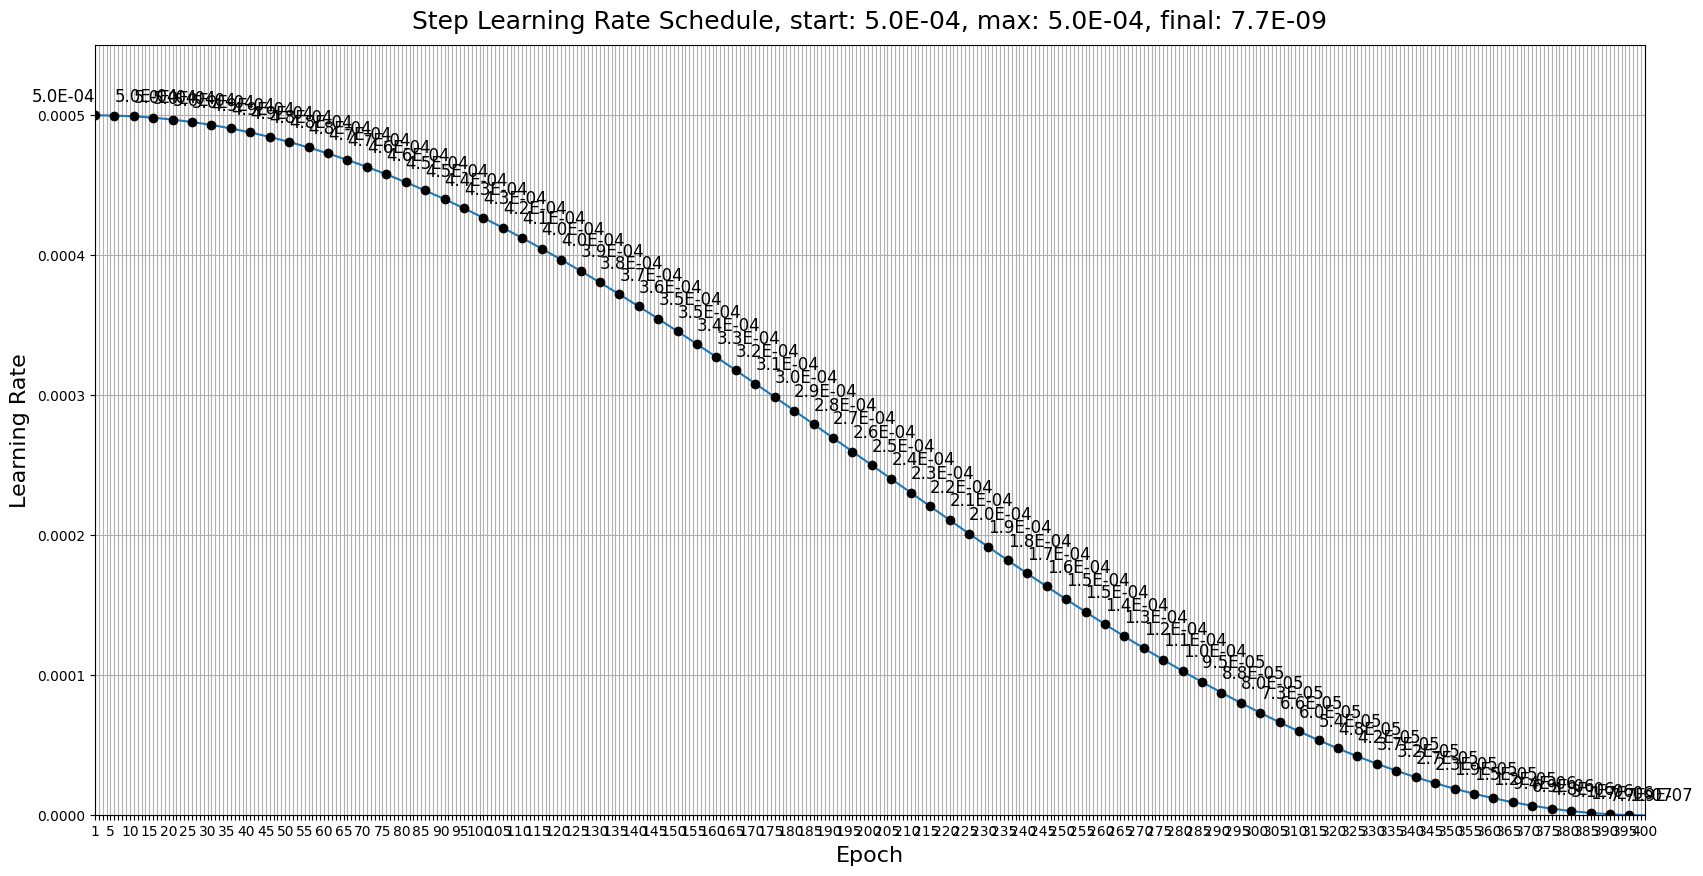

In [16]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

## Saving callback

In [17]:
save_folder = '/kaggle/working'
try:
    os.mkdir(f'{save_folder}/weights')
except:
    pass

class save_model_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%25 == 0:
            self.model.save_weights(f"{save_folder}/weights/model_epoch_{epoch}.h5")

## Training

In [18]:
steps_per_epoch = num_train//batch_size
val_steps_per_epoch = num_val//val_batch_size
print(steps_per_epoch)
print(val_steps_per_epoch)

2392
1


In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    verbose = 2,
    callbacks=[
        save_model_callback(),
        lr_callback,
    ]
)

Epoch 1/400
2392/2392 - 120s - loss: 0.2539 - val_loss: 0.2052 - lr: 5.0000e-04 - 120s/epoch - 50ms/step
Epoch 2/400
2392/2392 - 42s - loss: 0.2085 - val_loss: 0.1875 - lr: 4.9999e-04 - 42s/epoch - 18ms/step
Epoch 3/400
2392/2392 - 42s - loss: 0.1969 - val_loss: 0.1785 - lr: 4.9997e-04 - 42s/epoch - 18ms/step
Epoch 4/400
2392/2392 - 42s - loss: 0.1898 - val_loss: 0.1723 - lr: 4.9993e-04 - 42s/epoch - 18ms/step
Epoch 5/400
2392/2392 - 42s - loss: 0.1850 - val_loss: 0.1674 - lr: 4.9988e-04 - 42s/epoch - 18ms/step
Epoch 6/400
2392/2392 - 42s - loss: 0.1810 - val_loss: 0.1639 - lr: 4.9981e-04 - 42s/epoch - 18ms/step
Epoch 7/400
2392/2392 - 42s - loss: 0.1775 - val_loss: 0.1604 - lr: 4.9972e-04 - 42s/epoch - 18ms/step
Epoch 8/400
2392/2392 - 42s - loss: 0.1742 - val_loss: 0.1563 - lr: 4.9962e-04 - 42s/epoch - 18ms/step
Epoch 9/400
2392/2392 - 42s - loss: 0.1712 - val_loss: 0.1540 - lr: 4.9951e-04 - 42s/epoch - 18ms/step
Epoch 10/400
2392/2392 - 42s - loss: 0.1688 - val_loss: 0.1505 - lr: 4.

## Plotting loss

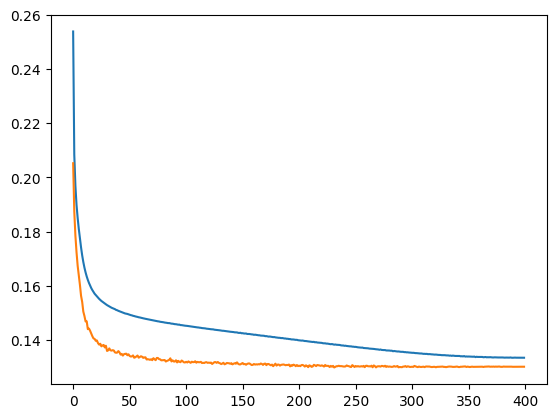

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Inference
Doing the inference in a separate notebook was easier, so I split it. Sorry about that. Find the inference notebook [HERE](https://www.kaggle.com/code/shlomoron/srrf-transformer-tpu-inference).